In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Alcohol_Sales.csv')
df

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DATE            325 non-null    object
 1   S4248SM144NCEN  325 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            325 non-null    datetime64[ns]
 1   S4248SM144NCEN  325 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


In [5]:
df['DATE'].iloc[0]

Timestamp('1992-01-01 00:00:00')

In [6]:
df = df.set_index('DATE')

###### Ploting time-series data

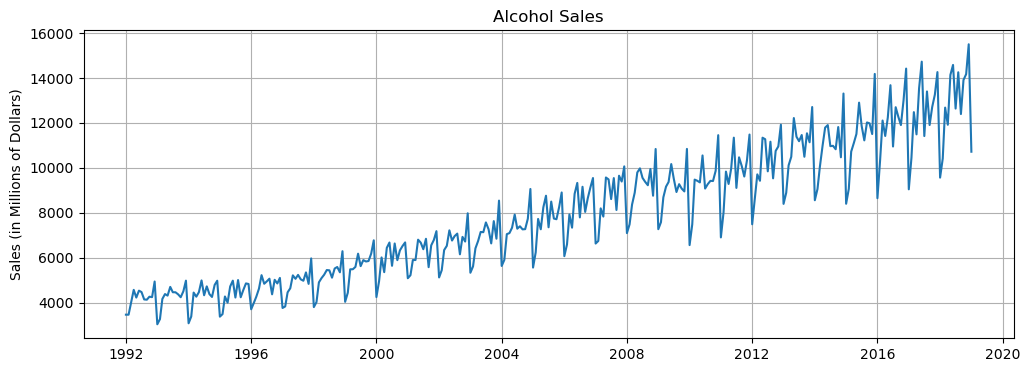

In [7]:
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in Millions of Dollars)')
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

###### Prepare the data

In [8]:
#Extract the values from .csv file

y = df['S4248SM144NCEN'].values.astype(float)

test_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [9]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

###### Normalize the data

In [10]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(-1,1))

In [11]:
#Normalize the trainsing set
train_norm = sc.fit_transform(train_set.reshape(-1,1))

In [12]:
train_norm.min()

-1.0

In [13]:
train_norm.max()

1.0

In [14]:
train_norm.mean()

-0.2041940178388313

###### Prepare data for LSTM

In [15]:
#convert train_norm from an array to  a tensor

train_norm = torch.FloatTensor(train_norm).view(-1)

#Define window
window_size = 12

#Define function to create seq/label tuples

def input_data(seq,ws):
    out= []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

In [16]:
train_data = input_data(train_norm, window_size)
len(train_data)

301

In [17]:
325-12-12

301

In [18]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

###### Define the model

In [19]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1,hidden_size =100, output_size =1):
        super().__init__()
        self.hidden_size = hidden_size
        
        #add LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        #add fully connected layer
        self.linear = nn.Linear(hidden_size,output_size)
        
        #Initialize h0 and c0
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                      torch.zeros(1,1,self.hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]
    

###### instantiate the model, define loss, optimization functions

In [20]:
torch.manual_seed(101)

model = LSTMnetwork()
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

In [21]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [22]:
params = [p.numel() for p in model.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>6}')

   400
 40000
   400
   400
   100
     1


###### Train the Model

In [23]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    for seq,y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
print(f'\n\n Duration: {time.time() - start_time: .0f} seconds')

Epoch:  1 Loss: 0.39908448
Epoch:  2 Loss: 0.37608618
Epoch:  3 Loss: 0.33051765
Epoch:  4 Loss: 0.44403607
Epoch:  5 Loss: 0.38091865
Epoch:  6 Loss: 0.38870922
Epoch:  7 Loss: 0.26088321
Epoch:  8 Loss: 0.55852532
Epoch:  9 Loss: 0.69110125
Epoch: 10 Loss: 0.24871595
Epoch: 11 Loss: 0.26348001
Epoch: 12 Loss: 0.23065567
Epoch: 13 Loss: 0.21849930
Epoch: 14 Loss: 0.20854042
Epoch: 15 Loss: 0.19991383
Epoch: 16 Loss: 0.20155382
Epoch: 17 Loss: 0.20834792
Epoch: 18 Loss: 0.21529414
Epoch: 19 Loss: 0.20540047
Epoch: 20 Loss: 0.19679511
Epoch: 21 Loss: 0.23258087
Epoch: 22 Loss: 0.15119700
Epoch: 23 Loss: 0.20934892
Epoch: 24 Loss: 0.26420873
Epoch: 25 Loss: 0.21212764
Epoch: 26 Loss: 0.19845314
Epoch: 27 Loss: 0.31067169
Epoch: 28 Loss: 0.21269475
Epoch: 29 Loss: 0.30981502
Epoch: 30 Loss: 0.29853472
Epoch: 31 Loss: 0.28783429
Epoch: 32 Loss: 0.33012369
Epoch: 33 Loss: 0.06675939
Epoch: 34 Loss: 0.20064209
Epoch: 35 Loss: 0.27488092
Epoch: 36 Loss: 0.14837348
Epoch: 37 Loss: 0.16345608
E

###### Predictions and comparison to known test set

In [24]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [25]:
preds[window_size:] #preds[-future:]

[0.5725580453872681,
 0.6362756490707397,
 0.5513218641281128,
 0.9133589267730713,
 1.0002970695495605,
 0.6909325122833252,
 1.079842448234558,
 0.5040112733840942,
 0.8658220767974854,
 0.7381258010864258,
 0.8910876512527466,
 0.19755876064300537]

###### Invert the normalizetion

In [26]:
true_predictions = sc.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
true_predictions

array([[12229.67828649],
       [12602.39440924],
       [12105.45724422],
       [14223.19304216],
       [14731.73770833],
       [12922.1097306 ],
       [15197.03840095],
       [11828.71394366],
       [13945.12623823],
       [13198.16687346],
       [14092.917216  ],
       [10036.11997038]])

In [27]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

###### Plot the results

In [28]:
x = np.arange('2018-02-01','2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

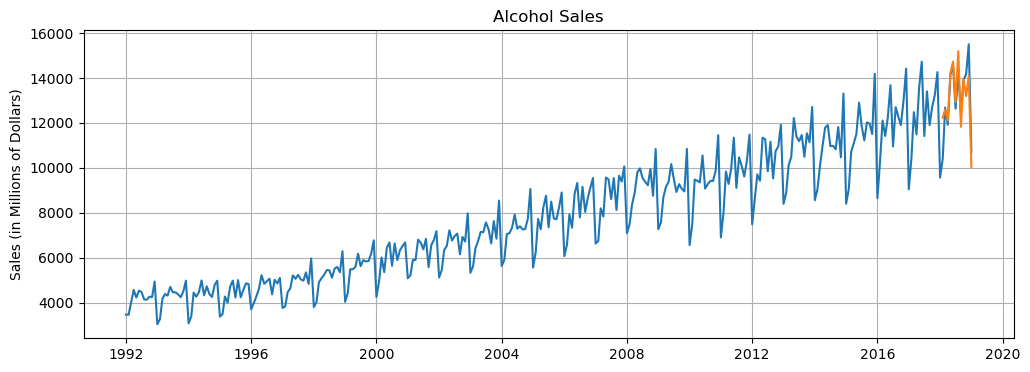

In [29]:
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in Millions of Dollars)')
plt.grid(True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

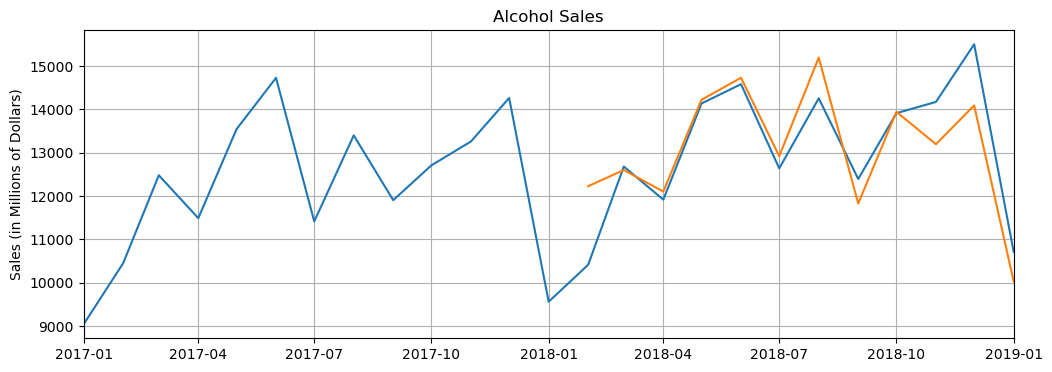

In [30]:
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in Millions of Dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)



plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

###### Forecasting into an unknown future

In [31]:
epochs = 100

model.train()

y_norm = sc.fit_transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    for seq,y_train in all_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
print(f'\n\n Duration: {time.time() - start_time: .0f} seconds')

Epoch:  1 Loss: 0.01730178
Epoch:  2 Loss: 0.00200402
Epoch:  3 Loss: 0.00413097
Epoch:  4 Loss: 0.00421920
Epoch:  5 Loss: 0.00493458
Epoch:  6 Loss: 0.00550053
Epoch:  7 Loss: 0.00674355
Epoch:  8 Loss: 0.00856032
Epoch:  9 Loss: 0.00964974
Epoch: 10 Loss: 0.01127029
Epoch: 11 Loss: 0.01172050
Epoch: 12 Loss: 0.01358234
Epoch: 13 Loss: 0.00765335
Epoch: 14 Loss: 0.00201523
Epoch: 15 Loss: 0.00279185
Epoch: 16 Loss: 0.01500730
Epoch: 17 Loss: 0.00002199
Epoch: 18 Loss: 0.00563734
Epoch: 19 Loss: 0.00316904
Epoch: 20 Loss: 0.00090342
Epoch: 21 Loss: 0.00726267
Epoch: 22 Loss: 0.00411152
Epoch: 23 Loss: 0.01046600
Epoch: 24 Loss: 0.00012633
Epoch: 25 Loss: 0.00105744
Epoch: 26 Loss: 0.00048693
Epoch: 27 Loss: 0.00017301
Epoch: 28 Loss: 0.00263084
Epoch: 29 Loss: 0.00178918
Epoch: 30 Loss: 0.00003788
Epoch: 31 Loss: 0.00064845
Epoch: 32 Loss: 0.00345661
Epoch: 33 Loss: 0.00347245
Epoch: 34 Loss: 0.00215277
Epoch: 35 Loss: 0.00146893
Epoch: 36 Loss: 0.00079281
Epoch: 37 Loss: 0.00419628
E

###### Predict the future values

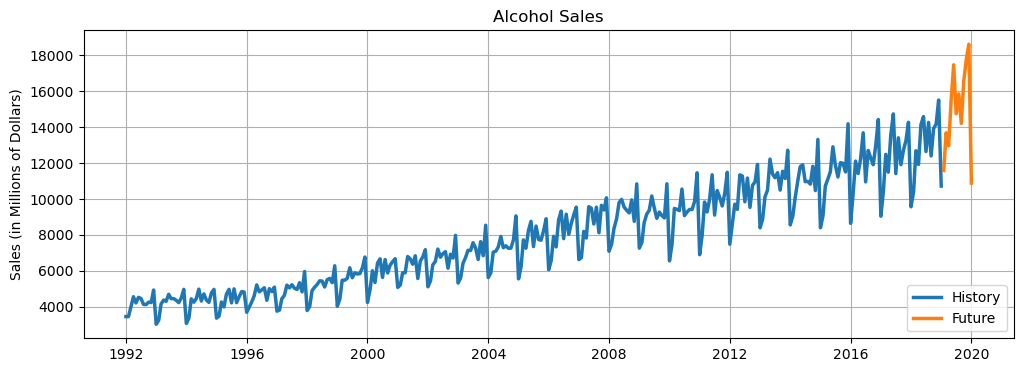

In [49]:
future = 12
window_size  = 12
L = len(y)
 
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
true_predictions = sc.inverse_transform(np.array(preds).reshape(-1,1))

x = np.arange('2019-02-01','2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in Millions of Dollars)')
plt.grid(True)
plt.plot(df['S4248SM144NCEN'], label='History',lw=2.5)
plt.plot(x,true_predictions[window_size:], label = 'Future',lw=2.5)
plt.legend(loc=4)
plt.savefig('sample.png',transparent=True)
plt.show()

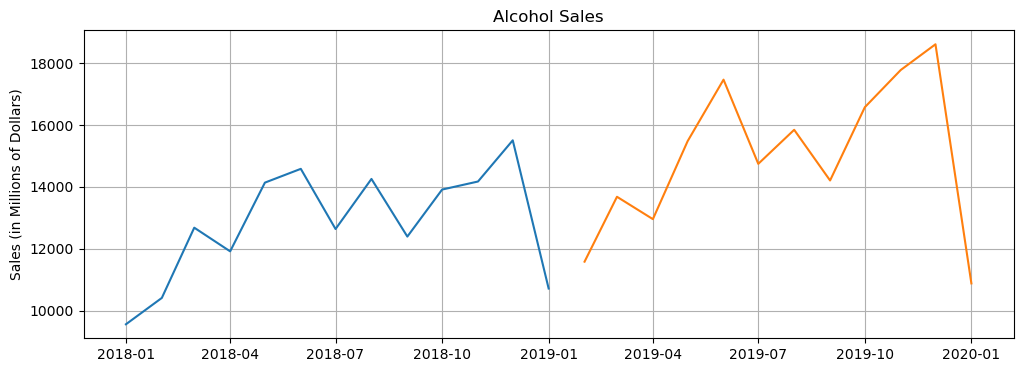

In [33]:
plt.figure(figsize=(12,4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (in Millions of Dollars)')
plt.grid(True)
plt.plot(df['S4248SM144NCEN']['2018-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()